In [ ]:
%%capture
!pip install git+https://github.com/PAGriAnalytics/pagri_analytics_modules.git

# Исследование объявлений о продаже квартир

**Описание проекта:**   
Проект направлен на исследование факторов, влияющих на ценообразование на рынке недвижимости в Санкт-Петербурге.  
В ходе проекта будут выявлены ключевые параметры, которые определяют стоимость квартир.  
Полученные знания будут использованы для создания системы, которая будет отслеживать аномалии и предупреждать о возможных случаях мошенничества.

**Автор:**  
Григорьев Павел   

**Цель:**    
Выявить ключевые параметры, определяющие стоимость квартир, и разработать рекомендации для создания системы мониторинга,   
которая поможет выявлять аномалии в ценах и предупреждать о мошенничестве на рынке недвижимости.

**Источники данных:**  
Данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.

**Условия проведения анализа днных:**  


>указываем временной интервал выборки  
>Например, 'для анализ будут использоваться данные за год с 1 июня 2017 по 31 мая 2018 года'

>Например, 'для анализ будут использоваться данные за год с 1 июня 2017 по 31 мая 2018 года'

**Главные выводы:**   
тут помещаем самое главное из общего вывода, примерно до полустраницы, чтобы не было сильно много и при этом указать все главные выводы
Будет идеально, елси выводы на похожие темы будут рядом, то есть елси мы имеем несколько выводов о доходе, то лушче поместить их рядом
- Женщины чаще возвращают кредит, чем мужчины.
- Долги присутствуют у людей с разным доходом.


**Аномалии и особенности в данных:**
- В датафрейме есть строки дубликаты. 54 строки. Меньше 1 % от всего датафрейма.  
- В столбце с количеством детей есть отрицательные значения. 47 штук. Меньше 1 процента от всего датафрейма. Также есть клиенты с 20 детьми.

**Рекомендации:**  
- Добавить контроль данных, чтобы не дублировались значения с разными регистрами в колонке с образованием.
- Добавить уникальный идентификатор клиента, чтобы избежать дублирования строк.


**Оглавление**


## Загрузка библиотек

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import pagri_data_tools  # type: ignore

## Описание и изучение данных

### Описание данных


По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных.  
Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

- airports_nearest - расстояние до ближайшего аэропорта в метрах (м)
- balcony - число балконов
- ceiling_height - высота потолков (м)
- cityCenters_nearest - расстояние до центра города (м)
- days_exposition - сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition - дата публикации
- floor - этаж
- floors_total - всего этажей в доме
- is_apartment - апартаменты (булев тип)
- kitchen_area - площадь кухни в квадратных метрах (м²)
- last_price - цена на момент снятия с публикации
- living_area - жилая площадь в квадратных метрах(м²)
- locality_name - название населённого пункта
- open_plan - свободная планировка (булев тип)
- parks_around3000 - число парков в радиусе 3 км
- parks_nearest - расстояние до ближайшего парка (м)
- ponds_around3000 - число водоёмов в радиусе 3 км
- ponds_nearest - расстояние до ближайшего водоёма (м)
- rooms - число комнат
- studio - квартира-студия (булев тип)
- total_area - площадь квартиры в квадратных метрах (м²)
- total_images - число фотографий квартиры в объявлении

### Изучение данных

#### Изучение переменных

Оставим тип float, так как у нас пропуски в данных и мы не можем преобразовать нужные столбцы в int

In [ ]:
dtype = {'is_apartment': 'category', 'studio': 'category', 'open_plan': 'category'}
df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', dtype=dtype, sep='\t'
                , parse_dates=['first_day_exposition'], date_format='%Y-%m-%dT%H:%M:%S')
df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)
df.sample(5, random_state=7)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
6029,7,4200000.0,42.00,2017-12-05,2,2.58,5.0,28.5,5,NaN,...,5.00,NaN,Санкт-Петербург,36416.0,9534.0,2.0,446.0,3.0,459.0,18.0
21836,7,3950000.0,45.00,2015-06-10,2,NaN,9.0,28.0,7,NaN,...,7.00,0.0,Санкт-Петербург,27880.0,12138.0,1.0,638.0,1.0,593.0,437.0
5698,7,450000.0,42.00,2017-07-31,2,NaN,1.0,23.0,1,NaN,...,5.80,NaN,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0
9402,11,4900000.0,55.00,2017-06-19,2,NaN,14.0,32.0,14,NaN,...,8.50,2.0,Санкт-Петербург,39931.0,12834.0,0.0,NaN,0.0,NaN,15.0
2519,6,3511000.0,39.41,2018-08-07,1,2.65,27.0,NaN,12,NaN,...,11.28,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,60.0


Изучим каждую колонку отдельно

In [ ]:
import pagri_prep

In [ ]:
import importlib
importlib.reload(pagri_prep)

<module 'pagri_prep' from '/home/pagri/git_repos/pagri_analytics_modules/pagri_prep.py'>

In [ ]:
gen = pagri_prep.my_info_gen(df)
next(gen)

Rows,Features,RAM (Mb),Duplicates,Dupl (sub - origin)
23 699,22,5,---,---


**Наблюдения:**
- Полных дубликатов в датафрейме нет

In [ ]:
next(gen)

In [ ]:
import io
import base64
from IPython.display import display, HTML


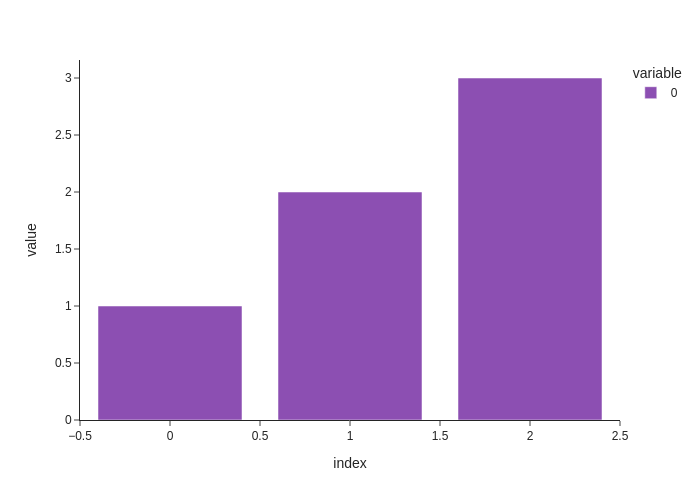

In [ ]:
res_df = pd.DataFrame([1,2,3]).style
buf = io.BytesIO()
fig = px.bar([1,2,3])
fig.write_image(buf, format='png')
buf.seek(0)
img_str = base64.b64encode(buf.read()).decode('utf-8')
final_html = f"""
<div style="display: flex; justify-content: flex-start; align-items: flex-end;">
    {res_df}
    <div>
        <img src="data:image/png;base64,{img_str}" alt="График"/>
    </div>
</div>
"""
display(HTML(final_html))

>ВАЖНО   
>Если увидели, что у нас в категориальной переменной одни и те же значения, но записанные с большой и с маленькой буквы, например,  
>или другие проблемы с написанием одно и того же слова, что приводит к увеличению значений в категории.   
>То нужно сразу это убирать, так как дальнейший анализ будет страдать.  
>Для дальнейшего анализа срауз приведем колонку education к нижнему регистру и удалим лишние пробелы

>Для дальнейшего анализа срауз приведем колонку education к нижнему регистру и удалим лишние пробелы

Нужно проверить, что после нормализации категориальный тип остался прежний

In [ ]:
df.education = pagri_prep.normalize_string_series(df.education)
df.education.value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [ ]:
df.education.dtype

>сделать предположения, почему могло так произойти, выдвигаем гипотезы

>придумать способы проверки выдвинутых гипотез и записать

>если у нас по оси x время, то проанализировать сезонность

>подумать а так и должно было получиться, основываясь на понимании физики параметра  

>зафиксировать возможные рекомендации

>Для гистограмм, нужно понять почему именно такое распределение метрики.  
>Совпадет это с логикой этой метрики.

>Также когда строим гистограммы и вайолин плот, то не просто фиксируем, что есть тяжелые хвосты, разброс между квартилями такой-то.  
>А думаем почему так, пытаемся связать это с физикой параметра. Должно быть физическое объяснение всех аномалий.  
>Если объяснения нет, то возможно это инсайт.  

>Важно убедиться, что у нас есть данные на все источники, которые заявлены. Например, мы изучаем источники трафика и у нас они в разных таблицах.  
>Нужно убедиться, что во всех таблицах есть все источники, и проверить нет ли аномалий, возможно какой-то сильно выбивается или какого-то вообще где-то нет.  

>И очень важно сверить, что периоды в разных таблицах (если у нас больше одной таблицы) совпадают.  

>Важно проверить соответствуют ли временной период данных тому, который заявлен в задании,  
>определиться что будем делать с неполными периодами.  

>Вообще, когда у нас несколько таблиц и там есть категориальные переменные или время, то  
>мы должны взять уникальные значения категориальных переменных из каждой таблицы (одниаковые переменные) и сравнить.  
>Количество уникальных должно совпадать, иначе нужно разбираться  
>И с верменем как минимум мин и макс даты должны совпадать до дня, а лушше до минуты часа

>Очень важно, если у нас есть стартовая дата чего-то и конечная, то обязательно нужно проверить,  
>нет ли у нас записей, где конечная дата меньше стартовой.  

>Важная проверка, если у нас есть категории и даты, то сгруппировать по категориями и
>вывести количество занчений, минимальную и максимальную дату  
>Таким образом мы сразу поймем распределение в категории и  
>увидем какие временные интервалы у каждой категории  
>Если у нас все категории должны быть в один день, то мы поймем нет ли багов

>Вообще очень важно смотреть не только на аномалии в значениях, но и аномалии в категориальных переменных.  
>А тут аномалией будет отстутствие какого-то значения, хотя в описании или поставновке задачи оно есть.  
>Также совпадение количества значений категориальных переменных в разных таблицах.  

>Внимательно посмотреть на столбцы, если есть столбцы, в которых могут быть потенциальные анамали, то проверить их.  
>Например, есть столбец возрасти стаж работы, проверить, что возраст больше стажа.  
>И подобные случаи.  

>Проверка на нарушения уникальности   
>Убедить, что столбцы, значения в которых не должны повторяться и должны быть уникальными, такие в действительности.    
>Смотрим на результат функции `my_info`

>Проверка на ошибки целостности  
>Если у нас есть столбцы, в которых значения должны совпдаать попарно, то проверяем на это  
>`get_non_matching_rows`

In [ ]:
pagri_data_tools.get_non_matching_rows()

>Проверка условий  
>Проверьте, что данные в датафрейме удовлетворяют определенным условиям, таким как "возраст > 18" или "страна == 'Россия'"

#### Изучение дубликатов

>Не забываем про ИИ.  
>Пишем список столбцов (именно что они значат, то есть образование, пол и прочее), говорим, что есть дубли.  
>И просим предложить причины этих дублей. Если видим важное, то используем для рекомендаций, выводов и замены дублей в предобработке.  

>Проверяем на дубли  
- Важно помнить, что если у нас есть id и название товара, то названия товара все равно нужно проверить на дубли,  
>возможно у нас 2 ай ди с одним названием.
- Также важно в каждой отдельной колонке проверить дубли и если их много, то посмотреть на соседние колонки, что там происходит
- Дубликаты часто носят скрытый характер.  
>То есть это могут быть поля, которые записаны  по разному, но относятся к одному и тому же.  
>Поэтому важно, если у нас категориальный признак, изучить нет ли повторящихся категорий, которые записаны немного по разному.  
>Так как это создает шум, мы по сути имеем две разные категории, но на самом деле это одна. Нужно собрать их в одну.  
- И очень важно, если мы не подтвердили, что это действительно дубликат (например у нас нет ай ди клиента и мы не смогли выяснить один и тот же ли это человек),  
>то нужно аккуратно удалять их. Но и оставлять много дублей плохо, так как они вносят шумы и искажения.  
- Помним, что наличие дубликата не говорит точно, что это дубль, возможно у нас нет ещё колонок, котоыре бы детализировали и разделили эти дубли.  
>Поэтому тут могут быть рекомендации, чтобы добавли в фрейм доп колонки, которые помогут убрать дубли (либо сам ищешь ещё поля)


>Когда смотрим на дубли, то нужно ответить на вопрос так и должно быть, это нормально, что дубли в этих колонках.   
>Например у нас дубли во всех строках таблицы, нам нужно понять это может быть или этого не может быть, и нужно разбираться.   
>Аналогично когда смотрим колонки по 2, 3 и так далее, то самое главное, ответить на вопрос дубли могут быть в этих колонках.   
>Также когда разбиваем по категориям, задаем себе вопрос так могли распреедлеиться дубли.  

>`check_duplicated`  
>`check_duplicated_combinations_gen`  
>В первую функцию можно передавать весь датафрейм и можно выбирать нужные столбцы для проверки на дубли и передавать их.  

>Если мы нашли колонки в которых дубликатов не должно быть, то нужно изучить эти дубликаты по категориальным переменным в нашем датафрейме  
>`analys_by_category_gen`  

**Наблюдения:**
- Особых перекосов в сторону определенного значения в категории не наблюдается

>Идем по порядку с помощью next(gen)  
>если в выводе нет ничего интересного, то  выше помещаем ячейку с таким содержимым
>%%capture  
>next(gen)  
>снова выполняем next(gen), если снова ничего интересного то, к ячейке выше добавляем next(gen)  будет так  
>%%capture  
>next(gen);next(gen)  
>и так далее, пока не появится важная ячейка  
>далее оставляем эту важную ячейку и снова повторяем с первого пункта,  
>в итоге между ячейками с нужным выводом будут ячейки с запрещенным выводом и можно будет прогонять ноутбук весь целиком и выводы будут в нужнфх местах

>Посмотрим на дубли во всем датафрейме

In [ ]:
pagri_data_tools.check_duplicated()

>Посмотрим сколько у нас дублей в каждой колонке

In [ ]:
series_duplicated = pagri_data_tools.find_columns_with_duplicates(df)

>Посмотрим на строки датафрейма с дублями

In [ ]:
col1_duplicated = series_duplicated['col1']
col2_duplicated = series_duplicated['col2']

In [ ]:
col1_duplicated.head()
col2_duplicated.head()

In [ ]:
pagri_data_tools.check_duplicated_combinations_gen()
pagri_data_tools.analys_by_category_gen()

>Важно на дубли проверить и отдельные строки и целиком таблицу и подумать какие группы столбцов могут дать дубли и на это тоже проверить.  

>Если в дублях у нас есть ай ди клиента, то тут понятно, если нет ай ди, то пишем рекомендацию, чтобы данные приходили с ай ди,  
>чтобы можно было понять это один человек или нет

>Если у нас id пользователя встречается не одни раз в таблице и есть другие поля которые должны быть всегда одни и те же,  
>напримем пол и прочее, то нужно проверить у всех ли пользователей все значения одинаковые в этом столбце.  
>Это может быть не только ай ди, любое уникальное поле, которое повторяется и для каждого этого поля есть другое  
>поле, которое не должно меняться, нужно проверять а действительно ли это поле не меняется.  

#### Изучение пропусков

>Не забываем про ИИ.  
>Пишем название столбца (именно что они значат, то есть образование, пол и прочее), говорим, что есть пропуски.  
>И просим предложить причины этих пропусков. Если видим важное, то используем для рекомендаций, выводов и замены пропусков в предобработке.  

>Проверяем на пропуски

>Когда смотрим на пропуски, то нужно ответить на вопрос так и должно быть, это нормально, что пропуски в этих колонках.   
>Когда смотрим на пропуски по категориям, то думаем есть ли закономерность, не случайно ли распределение по категориям  

>Когда мы встречаем пропуски, прежде всего, нужно ответить на вопрос, существует ли закономерность в появлении пропусков.   
>Иными словами, не случайно ли их возникновение в наборе данных.  
>Случайно, значит нет закономерности с соседними столбцами, то есть пропуски есть для разных значений.  
>А могут быть неслучайные, то есть существует явная закономерностЬ, что пропуски есть только у сторок с общими занчениями в другом столбце.    
>Чтобы это проверить, нужно взять столбец с пропусками, отфильтровать только пропуски (взять их) и  
>посмотреть как эти пропуски распределены по другой переменной.    

- Первое что нужно сделать, когда мы видим пропуск или выброс, это проверить является ли оно случайным.  
>То есть посмотреть не относятся ли все выбросы к одной категории. Если это так, то это уже не случайно и мы нашли аномалию, которую можно изучать.  
>Если у нас случайны разброс пропусков в категориях, то значит тут есть случайность.  
>Например, у нас возраст 0, и мы видим, что больше всего это у женщин. Следовательно получаем гипотезу, что женщины не хотят сообщать свой возраст.  
- В пропусках мы можем определить какие категории, платформы и прочее не собираются данные. Смотрим пропуски, далее смотрим у каких категорий их больше,  
>и получаем вывод, что нужно обратить внимание на эти категории или системы, почему там пропуски

>`find_columns_with_missing_values`  
>`check_na_in_both_columns`  
>`analys_by_category_gen`

In [ ]:
series_missed = pagri_prep.find_columns_with_missing_values(df)

days_employed,2174 (10.10%)
total_income,2174 (10.10%)


>Посмотрим на строки датафрейма с пропусками

In [ ]:
col1_missed = series_missed['col1']
col2_missed = series_missed['col2']

In [ ]:
col1_missed.head()
col2_missed.head()

>Посмотрим сколько пропусков в обоих колонках вместе

In [ ]:
pagri_data_tools.check_na_in_both_columns()

>Изучаем пропуски по категориям

>Смотрим на все поля  
>in_category_pct говорит о том сколько в этом значении категории изучаемых значений  
>in_column_pct говорит о том сколько процентов изучаемого значения данного значения категории в общем  
>total_count_pct помогает анализировать in_column_pct, так как мы видим сколько занимает это значение в общем  

In [ ]:
gen = pagri_prep.analys_by_category_gen(df, series_missed, is_dash=True)


In [ ]:
next(gen)

In [ ]:
gen = pagri_prep.analys_by_category_gen(df, series_missed, is_dash=True)

In [ ]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


#### Изучение выбросов

>Не забываем про ИИ.  
>Пишем название столбца (именно что они значат, то есть образование, пол и прочее), говорим, что есть выбросы.  
>Обязательно приводим значения выбросов, самые характерные, чтобы дать ИИ болше информации.
>И просим предложить причины этих выбросов. Если видим важное, то используем для рекомендаций, выводов и замены выбросов в предобработке.  

>Когда смотрим на выбросы, то нужно ответить на вопрос так и должно быть, это нормально, что выбросы в этих колонках.   

- Выбросы это не только просто сильно большое или сильно маленькое значение.  
- Выбросы нужно также смотреть по мультипараметрам, с помощью моделей и искать аномалии.  
- Выброс это то, что отделяется от других, что выбивается из общей картины. Следовательно это что-то особенное.  
- Тажке выбросы говорят не только о плюсах, но и о минусах. Выбросы могут сказать, что у нас что-то сломалось.  
>Что-то не записывается, или работает с багами. Все это можно увдитеь по выбрасам и аномалиям.  
- Обязательно посмотреть выбросы в разрезе категорий, так как мы сможем сделать выводы об их источнике.  
- Если мы работаем со строгой отчетностью, то тут любой выброс это уже инсайт и нужно идти разбираться откуда это взялось.  

>Если мы во время изучения данных выявили потенциальные выбросы, то нужно их отдельно изучить.    
>Для этого создаем датафрейм с нужными значениями и помещаем его в `Series`,  
>индекс это название колонки, в которой мы изучаем выброс.  
>Далее отдаем этот  `Series` в функцию `analys_by_category_gen`.

>Сначала изучим потенциальные выбросы, которые мы выявили при изучении колонок.  
>У нас в количестве детей есть значение 20.   
>Изучим его подробнее.  

>Важно при изучении колонок записывать выбросы отдельно и потом коппировать сюда.  
>А тут нужно изучить эти значения отдельно.

In [ ]:
outliers_series = pd.Series([df[df.children == 20]], index=['children'])
gen = pagri_data_tools.analys_by_category_gen(df, outliers_series)
next(gen)

>Смотрим на выбросы используя Z-score  
>`detect_outliers_Zscore`

In [ ]:
series_outliers = pagri_data_tools.detect_outliers_Zscore()
# сначала смотрим на значения с большим количеством выбросов
series_outliers['col'].col.value_counts().to_frame('outliers')
# затем уже изучаем определенные датафреймы в series_outliers
series_outliers['col'].head()

>Смотрим на выбросы используя квантили  
>`detect_outliers_quantile`

In [ ]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df)

>Посмотрим на строки датафрейма с пропусками

In [ ]:
col1_outliers = series_outliers['col1']
col2_outliers = series_outliers['col2']

In [ ]:
col1_outliers.head()
col2_outliers.head()

>Изучить выбросы по категориями  
>`analys_by_category_gen`  

>Смотрим на все поля  
>`in_category_pct` говорит о том сколько в этом значении категории изучаемых значений  
>`in_column_pct` говорит о том сколько процентов изучаемого значения данного значения категории в общем  
>`total_count_pct` помогает анализировать `in_column_pct`, так как мы видим сколько занимает это значение в общем  

In [ ]:
gen = pagri_data_tools.analys_by_category_gen(df, series_outliers)
next(gen)

#### Изучение отрицательных значений

>Не забываем про ИИ.  
>Пишем название столбца (именно что они значат, то есть образование, пол и прочее), говорим, что есть отрицательные значения там где их быть не должно.  
>Обязательно приводим значения, самые характерные, чтобы дать ИИ болше информации.
>И просим предложить причины этих отрицательных значений. Если видим важное, то используем для рекомендаций, выводов и замены отрицательных значений в предобработке.  

>Очень важно, если у нас есть столбец, в котором не должно быть отрицательных значений, то нам нужно отдельно изучить положительные и отрицательные значения.  
>И те и те посмотреть по категориям.  
>И на основе этого изучения мы моежм заметить причины отрицательных значений.  
>Например, в колонке стажа у нас очень много отрицательных значений и есть положительные значения.  
>Мы отдельно посмотрели отрицательные значения и они в основном принадлежат работающим людям.  
>А положительные пренадлежат пенсионерам.   
>Важно и полоительные и отрицательные значения посмотреть их макс и мин.   
>Вот мы для стажа посмотрели макси и мин и видим, что отрицательные значения похожи на реальные значения в годах.   
>А вот положительные слишком большие, и далее мы поняли, что это данные в часах.  
>В итоге у нас уже много предположений, которые помогут выяснить откуда появляются странные данные в этом столбце.  
>К тому же мы можем попробовать заменить отрицательные значения, если у нас есть уверенность на основе анализа.  

>Изучаем отрицательные значения

In [ ]:
series_negative = pagri_data_tools.find_columns_with_negative_values(df)

>Определяем в каких колонках не должно быть орицательных значений.  
>Колонки в которых допустимы отрицательные значения удаляем из `series_negative`

>Изучим отрицательные значения в разрезе категорий

>Смотрим на все поля  
>in_category_pct говорит о том сколько в этом значении категории изучаемых значений  
>in_column_pct говорит о том сколько процентов изучаемого значения данного значения категории в общем  
>total_count_pct помогает анализировать in_column_pct, так как мы видим сколько занимает это значение в общем  

In [ ]:
gen = pagri_data_tools.analys_by_category_gen(df, series_negative)
next(gen)

#### Изучение нулевых значений

>Не забываем про ИИ.  
>Пишем название столбца (именно что они значат, то есть образование, пол и прочее), говорим, что есть нули там, гед их быть не должно.  
>И просим предложить причины этих нулей. Если видим важное, то используем для рекомендаций, выводов и замены нулей в предобработке.  

>Изучаем нулевые значения

In [ ]:
series_zeros = pagri_data_tools.find_columns_with_zeros_values(df)

>Определяем в каких колонках не должно быть нулевых значений.  
>Колонки в которых допустимы нулевые значения удаляем из `series_negative`  


In [ ]:
series_zeros = series_zeros.drop('children')
series_zeros

dob_years           children  days_employed  dob_years educ...
dtype: object

>Изучим нулевые значения в разрезе категорий

>Смотрим на все поля  
>in_category_pct говорит о том сколько в этом значении категории изучаемых значений  
>in_column_pct говорит о том сколько процентов изучаемого значения данного значения категории в общем  
>total_count_pct помогает анализировать in_column_pct, так как мы видим сколько занимает это значение в общем  

In [ ]:
gen = pagri_data_tools.analys_by_category_gen(df, series_zeros)
next(gen)

>После изучения данных у нас могут возникнуть вопросы по определенным значениям, это возможно не выбросы,  
>мы просто хотим подробнее их изучить.    
>Для этого создаем датафрейм с нужными значениями и помещаем его в `Series`,  
>индекс это название колонки, в которой мы изучаем выброс.  
>Далее отдаем этот  `Series` в функцию `analys_by_category_gen`.  
>Нужно сделать специальную функцию для этого, чтобы не использовать `analys_by_category_gen`

In [ ]:
check_series = pd.Series([df[df.col_for_check == value_for_check]], index=['col_for_check'])
gen = pagri_data_tools.analys_by_category_gen(df, check_series)
next(gen)

>Также мы можем изучить любые столбцы (или часть столбцов) по категориям.  
>То есть мы изучаем как распределены элементы по категориям

In [ ]:
check_series = pd.Series([df[df.col_for_check == value_for_check]], index=['col_for_check'])
gen = pagri_data_tools.analys_by_category_gen(df, check_series)
next(gen)

>Сделать функцию определения выбросов на основе машинного обучения

>Дополнительные моменты, которые стоит проверить и изучить
- Проверить на сложные выбросы, типа у нас есть статус и возраст и мы видим что студент имеет возраст 60 лет, это реально, но уже подозрительно.  
>Вот таких моментов может быть много, но нужно додуматься, чтобы найти такие комбинации, но это важно делать.
- важно проверить на корректность данные, то есть смотрим по отдельности каждый столбец и изучаем мин, макс, и другие параметры, и  
>думаем, это физически реально. И особенно, когда у нас несколько связаных параметров, нет ли между ними противоречия.  
>Например, у нас есть дата показа рекламы и есть дата создания рекламы, естественно создание должно быть раньше, это нужно проверить.  
- Проверяем данные ошибки  
>Ошибки которые не являются дублями, пропусками или выбросами.  
>Это сложно сделать, хотя бы заметить явные ошибки
- Проверить на ошибки согласованности  
>Например, у нас пользователь с одним ай ди имеет разные имена.
>`display(df.groupby('name')['age'].nunique())`
- вообще нужно придумать разные проверки для колонок, особенно связанных. И провести эту проверку.

### Промежуточный вывод

>Из наблюдений собираем важные выводы

>Принимаем решение, как именно мы будем проводить обработку, почему именно так, *зафиксировать рекомендации.  
>То есть отвечаем на вопрос, что будем делать с выбросами, что будем делать с null.  
>Будет идеально если тут зафиксировать рекомендации  


**Промежуточный вывод**
>
- **children** Присутствует 47 отрицательных значений с "-1", а также аномалия в виде 20 детей ...
- **days_employed** Большая часть данных стобца со знаком "-". Однако, эти данные представляют из себя 84% всей выборки. ... будут заменены на .. исходя из определенного критерия, который будет описан далее.
>    - Причины пропущенных значений в столбцах **days_employed** и **income**:
>        - Во-первых, это может быть из-за неправильной выгрузки данных. Оставим это предположение до того момента, пока не убедимся в неверности других предположений.**Наиболее вероятно**
>        - Во-вторых, одной из гипотез было предположение об отсутствии трудового опыта у данной части выборки. Однако, если распределение по возрасту в данной группе равномерное по всем возрастам выборки. Также большая доля этой части выборки трудоустроена. **Гипотеза не подтверждена**
>        - В-третьих, возможно, что эта часть выборки не имеет официального трудоустройства. Данная гипотеза вызывает сомнение в связи с тем, что при наличии достаточно большого стажа работы у представителей выборки у ее представителей нет официального трудового стажа. К тому же 18.9% данной выборки являются госслужащими. **Гипотез не подтверждена**
- **age** .. 0 возраст у 101 человека.
- **education & education_id** Необходимо будет привести данную категорийнуй переменную к общему виду. Избавиться от разного регистра. Но можно не тратить на это время и использовать следующий столбец **education_id**. Это позволит использовать меньше памяти и не повлияет на качество анализа.
- ...

## Предобработка данных

>Важно, когда удаляем строки, то делаем сброс индекса

In [ ]:
.reset_index(drop=True)

>Не забываем про ИИ  
>Когда мы проводим предобработку данных, то первый вопрос мы себе задать следующий
>Какава вероятнсоть, что это является истиной? Если вероятнсоть ниже 60 прцоентов, то это делать не стоти и может лучше оставить как есть или не трогать этот столбец.  
>Например, у нас дубли или отрицательные значеия и мы выдвинули гипотезу, что это просто неправильный знак и хотим взять модель числа.  
>Но если мы подумаем, а высокая ли вероятность, что число просто с неверным знаком, то вероятнсот этого низкая.  
>Поэтому это делать не нужно.   
>Другое дело у нас датафрейме 1 прцоент полных дублей и при этом у нас есть достаточно точные колонки типа зарплаты с точностью до рублей или стаж в днях.  
>Вот тут мы можем с высокой вероятностью утверждать, что это дубли, так как мало вероятно что будет две записи настолько точно совпадать.  
>Поэтому сначала думаем насколько вероятна та гипотеза, которую мы выдвинули и хотим по ней изменить наши данные.  
>Тут лучше придерживаться правила не навреди.

>Когда удаляем значения из категориальных столбцов pandas, и в этом столбце нет больше таких занчений, которые удалил.  
>То нужно удалить это значение из категории

In [ ]:
df.drop(df[df.gender == 'XNA'].index, inplace=True)
df['gender'] = df['gender'].cat.remove_unused_categories()
df.value_counts(dropna=False)

In [ ]:
df.shape[0]

### Обрезание неполных временных периодов

>Если у нас датасет за год, например, и первый или последний месяц неполные, то их лучше выбрасить, если мы будем  
>расчитывать месячные метрики.  
>Но сначала конечно нужно проанализировать столбцы без обрезания, чтобы убедиться, что там нет ничего необычного.  

### Выбор нужных столбцов для дальнейшей работы

>Сохраним исходный датафрейм в переменную df_origin, чтобы была возможность вернуться к нему


In [ ]:
df_origin = df.copy()

>Удаляем ненужные столбцы

In [ ]:
df = df.drop(['col1', 'col2'], axis=1)
df.head(1)

- Думаем, какие колонки нам нужны, выбираем только их для дальнейшей работы.  
>Остальные убираем в другой датасет.
- Важно после изученя данных сначала убрать не нужные столбцы, а потом уже заниматься преобразованием (удалением пропусков и выбросов).  
>Думаем прежде чем удалять строки, так как возможно лучше удалить столбец и строки удалять будет не нужно.  
- Пишем почему выбираем определенные столбцы

### Обработка выбросов

>Не забываем про нулевые значения и отрицательный.  
>В столбцах, где их быть не должно, они являются выбросами.  

>С обработкай нулевых и отрицательных значений нужно быть внимательным.  
>Нужно сначала хорошо подумать, откуда могло это появиться,  
>тут поможет анализ этих значений в предыдущей главе.  
>Думаем откуад появилось отрицательное или нулевое занчение,  
>и если у нас есть гипотезы, которые похожи на правду (мы думаем что вероятность их истины больше 60%),  
>то мы обрабатываем их исходя из гипотезы.  
>Например, -1 часто бывает как отсутсвие чего-то, то есть мы в зависимости от контекста можем заменить его на 0.  


>Важно каждый раз, когда мы удаляем что-то из датафрейма, то убедиться, что мы удалили столько строк, сколько и хотели.  
>Для этого выводим размер датафрейма до удаления.  
>Смотрим сколько строк мы хотим удалить.  
>Далее не сохраняя в датафрейм удаляем строки и смотрим верный ли итоговый размер.  
>Если все верно, то удаляем уже с сохранением.  

>Не забываем, что выбросы мы также можем заменять на медианные значения.

In [ ]:
df.shape[0]

21525

In [ ]:
df = df[df.children >= 0]
df.shape[0]

21478

>Посмотрим где у нас отрицательные значения

In [ ]:
pagri_data_tools.check_negative_value_in_df(df)

>Посмотрим где у нас нулевые значения

In [ ]:
pagri_data_tools.check_zeros_value_in_df(df)

>Обрабатываем нулевые и отрицательные значения, затем снова проверяем

In [ ]:
pagri_data_tools.check_negative_value_in_df(df)

,negative


In [ ]:
pagri_data_tools.check_zeros_value_in_df(df)

,zeros


>Также нужно обработать выбросы, которые мы обнаружили при изучении данных.  
>Это могут быть любые колонки со значениями, которые не моут быть в реальности.  

>Нужно сначала обработать выбросы, а потом уже обрабатываться пропуски.  
>Так как мы заоплняем пропуски, учитывая значения в колонке, которые возможно мы потом удалим.  

- Помним про нулевые и отрицательные значения
- Нулевые значения, отрицательные значения являются выбросами, если они не могут быть у этой колонки.  
- Очень важно понимать, когда выброс можно отбросить и он реально выброс и когда нельзя.  
>Опираемся на физику параметра, думаем это значение физически возможно.  
- Также выброс может казаться выбрасом, но для бизнеса это не выброс.  
>Например у нас суммы покупок и одна покупка сильно выделяется, а там просто человек купил супе дорогой каньяк, например.  
- Когда хотим обрезать выбросы, то думаем, какой порог может быть физически реальным и по нему режем, а не просто так берем какой-то перцентиль.  
>Всегда нужно думать с точки зрения физического возможного значения параметра и по нему резать (подумать а какое значение может быть максимально реальным и по нему обрезать)
- Если мы имеем дело со строгой отчестностью, то выбросы убирать нельзя, нужно разобраться откуда они.  
- Если мы не можем с увереностью сказать, что это выброс, то нам не стоит его выкидывать, но работать как то нужно с ними,  
>тогда, логарифмируем (лучше использовать натуральный логарифм) эту колонку и работаем с такими значениями (тогда выбросы сожмуться).  

>После удаления выбрасов, можно снова выполнить пункт про изучение выбрасов, так как выбросы могут появиться новые,   
>если у нас например выбросы были слишком нереальные значения, когда мы от них избавимся, будет лучше видно другое

### Обработка пропусков

> Важно помнить, что пропус может быть вызван тем, что во измежании дублирования строк, при созаднии сводной таблицы,  
занчения не повторяются, а если потом эту таблицу куда то отправить, то там эти пропуски могут стать null  
Поэтому сначала смотрим последовательно на значения и думаем, не может ли это быть таким случаем.  
Это могут быть даты, которые идут подряд и меду ними пропуски.  
Или список названий четко по порядоку и между ними пропуски, это может быть вызвано как раз последствием создания сводной таблицы.  
В пандас это видно, когда мы группируем строки, у нас в индексе дубли не пишуться, но пандас занчет, что там есть занчения,  
но после импорта куда-то там могут не продублироваться значения и возникнут пропуски.  

>Прежде чем обрабатывать пропуски, нужно подумать а можем ли мы их заменить исходя из имеющихся столбцов.  
>Например, у нас есть столбец с пропусками возраст, и есть стаж,  
>мы можем возраст заменить так стаж + 18 + 5  
>Аналогично другие ситуации нужно сообразить как можно заменить пропуски.  
>И только если нет идей, тогда уже заменяем на медиану, например, по группам.  

In [ ]:
pagri_data_tools.check_missed_value_in_df(df)

>Если решии заменять прпоуски значениями, учитывая категории, то нужно убедиться, что размер этих категорий достаточный.

>Посмотрим размеры групп, если заменять внутри этих групп

In [ ]:
category_columns = ['education', 'family_status', 'gender', 'income_type']
value_column = 'total_income'
pagri_data_tools.check_group_count(df, category_columns, value_column)

>Заполним пропуски в группах от 10 элементов

In [ ]:
df[value_column] = pagri_data_tools.fill_na_with_function_by_categories(df, category_columns, value_column, func='median', minimal_group_size=10)

>Проверим сколько у нас осталось пропусков

In [ ]:
pagri_data_tools.check_missed_value_in_df(df)

>Если пропуски остались, то убираем какую-нибудь категорию и повторяем.

>что-то изменили - > посмотрели не изменилось ли количество дублей   
>`check_duplicated`

In [ ]:
pagri_data_tools.check_duplicated()

>Увидели пропуск - подумайте, нормально ли это. Сколько вообще пропусков может быть в этом столбце?   
>К примеру, в списке с электронными адресами пользователей, согласных на рассылку, будет много пропусков. Далеко не все предоставляют email.

>Можно использвоать такой подход
- если количество пропусков меньше 5 процентов, то удаляем (лучше меньше 1 процента)
- если количество пропусков от 5 до 20 процентов, то подбираем чем заменить, удалять не стоит
- если больше 20 процентов, то не трогаем, так как исказим

>Но оставляя пропуски, нам нужно помнить, что мы не можем по этим полям считать корреляцию с другими,   
>так как пропуски испортят расчет коэффициента корреляции. Аналогично другие метрики могут считаться некорректно.  
>Поэтому, если мы будем считать показатели по столбцу с пропусками, то их нужно либо убирать, либо этот столбец не использовать для расчетов.  

>Для категориальных переменных оставлять пропуски нельзя, так как мы скорее всего будем группировать по ним и смотреть разные разрезы.  
>Поэтому в худшем случае, если не можем ничем заменить, и нет уверености, что пропуск можно заполнить пустой строкой (если значения физически нет),  
>то создаем категорию например `other` из пропусков.  

>Если у нас пропуски в категориальной переменной и есть разные периоды или просто данные разбиты на части (то есть эта категориальная переменная повторяется),  
>то мы можем взять ещё какую-нибудь переменную, у которой нет пропусков, где пропуски у первой переменной и далее посмотреть другие периоды  
>Таким образом у нас будет предыдущий период, где будет занчение второй переменной и первой и если в нескольких периодах они одинаковые, то мы можем  
>заполнить и пропуски этим значением.   
>Ещё раз схема такая - берем 2 поля одно с пропусками, другое без, получаем новую таблицу, в этой таблице оставляем только униклаьные значения в поле без пропусков,  
>по этому полю будем джойнить. Далее в основнйо таблице дропаем описание и создаем новое описание из таблицы справочника.    
>`fill_missing_values_using_helper_column`

In [ ]:
pagri_data_tools.fill_missing_values_using_helper_column()

>Заполняем пропуски учитвая категории  
>`fill_na_with_function_by_categories`

>Важно следить, чтобы категории, по которым будем заполнять пропуски были обработаны.  
>Если у нас в категориальной переменной есть значение с большой буквы и с маленькой, то это одна категория,  
>но замена будет идити по двум, чтобы такого не было, нужно сначала обработать  категориальную переменную.  


>Также важно, чтобы в группах по которым мы будем считать значение для заополения было достаточно значений  
>для выбранной функции.  
>Например, если мы решили брать среднее, а в группе у нас 5 значений, то среди них может быть выброс и наше среднее будет некорректно.  
>Лучше в такой ситуации брать группу побольше для этих микрогрупп.  
>В идеале группы должны быть от 30 элементов.  

>Можно посмотреть какой процент группах без значений

In [ ]:
temp = df.groupby(['education', 'family_status', 'gender', 'income_type'])['total_income'].sum()
(temp == 0).sum() * 100 / temp.size

In [ ]:
pagri_data_tools.fill_na_with_function_by_categories()

>Сделать функцию заполнения пропусков с помощью машинного обучения

>После удаления пропусков и выбросов желательно проверить какой прцоент строк мы удалили.  

### Обработка дубликатов

>Все значения в колонках во всех таблицах нужно привести к нижнему регистру и по возможности к одному языку,  
>для перевода к одному языку можно использовать словарь, с помощью которого изменить неправильный язык  
>Это нужно, чтобы когда будем соединять таблицы, у нас условие соеденения правильно сравнивало равные значения.  

>Можно посмотреть снвоа на дубликаты после обработки пропусков.  

>`check_duplicated`   
>`find_columns_with_duplicates`   
>`check_duplicated_combinations_gen`    
>`get_duplicates_value_proportion_by_category`  
>В первую функцию можно передавать весь датафрейм и можно выбирать нужные столбцы для проверки на дубли и передавать их.  

In [ ]:
pagri_data_tools.check_duplicated()

In [ ]:
pagri_data_tools.check_duplicated_value_in_df(df)

In [ ]:
pagri_data_tools.find_columns_with_duplicates()

>Заполним пропуски в группах от 10 элементов

In [ ]:
df[value_column] = pagri_data_tools.fill_na_with_function_by_categories(df, category_columns, value_column, func='median', minimal_group_size=10)

In [ ]:
pagri_data_tools.check_missed_value_in_df(df)

,missed
total_income,63 (0.3%)


>Если есть дубли, и мы считаем, что это не дубли, а просто разделились данные,    
>то объединеняем записи, которые имеют одинаковые значения ключевых признаков.  
>`merge_duplicates`

In [ ]:
pagri_data_tools.merge_duplicates()

>Если мы не уверены, что дубль является дублем и не хотим удалять, то можно  использовать  
>маркировку дублей,  можно добавить новую колонку, которая будет содержать информацию о том,   
>является ли строка дубликатом или нет.  
>`df['is_duplicate'] = df.duplicated()`

In [ ]:
df['is_duplicate'] = df.duplicated()

>Подумать, а можем ли мы обогатить данные, что разделит дубли.  
>То есть возможно в наших данных нет какого-то столбца, и тогда дубли уже не будут дублями.

>Если уверены, что это дубли, то удаляем их  
>`df.drop_duplicates()`

In [ ]:
df.drop_duplicates()

###  Приведение данных к удобной форме

>Изменяем значения в столбцах на более удобные

In [ ]:
df.is_apartment.value_counts(dropna=False)
app = df.is_apartment.apply(lambda x: 'да' if isinstance(x, bool) else 'нет').astype('category')
app.value_counts(dropna=False)
# df.debt = df.debt.apply(lambda x: 'есть' if x == '1' else 'нет').astype('category')

>Если у нас в столбце, например, стаж данные в днях, то это нужно преобразовать в года.  
>Также если у нас в других столбцах данные в формате, который нужно изменить для лучшего анализа, то делаем это.  

>Округлим значения в поле дохода до целого.  
>Целая часть выглядит реальной. А с дробной частью нужно разбираться почему стоько знаков.  

In [ ]:
df.total_income = df.total_income.round().astype('int32')
df.head(1)

,children,age,education,family_status,gender,income_type,debt,total_income,purpose
0,1,42,высшее,женат / замужем,F,сотрудник,0,253876,покупка жилья


>Посмотрим сколько у нас людей с полом XNA осталось

In [ ]:
(df.gender == 'XNA').sum()

1

>Посмотрим кто это

In [ ]:
df[df.gender == 'XNA']

,children,age,education,family_status,gender,income_type,debt,total_income,purpose
10701,0,24,неоконченное высшее,гражданский брак,XNA,компаньон,0,203905,покупка недвижимости


>Всего 1 человек. И мы не можем идентифицировать его пол.  
>Удалим, чтобы не мешало анализировать графики.  

In [ ]:
df.shape[0]

21402

In [ ]:
df.drop(df[df.gender == 'XNA'].index, inplace=True)
df['gender'] = df['gender'].cat.remove_unused_categories()
df.value_counts(dropna=False)

21401

In [ ]:
df.shape[0]

### Категоризация данных и создание новых переменных

>Если у нас есть категориальная переменная, в которйо больше 3 значений, то нужно подумать а не можем ли мы из нее сделать  
>новую категориальную переменную с 2-3 значениями, но тут важно, чтобы это несло смысл. Тут нам может помочь ИИ. И сообразительнсоть. Часто сразу не заментны возможные категории,  котоыре несут смысл.  
>Тут исходим из смысла, наша задача созадть перменную, которая добавит нашему исследованию новый смысл, даст как бы новый разрез, и это улучшит   
>качество наших выводов.    
>Например, у нас столбец семейный стату, и там 6-7 статусов, мы можем собрать их в 2 семейный статус и не семейный статус.  
>Тут отлично помогает ИИ. Пишешь ему название переменной, униальные значения в ней,  
>и просишь придумать возможную новую категориальнуюд переменную из 2-3 значений.  

>Вообще при категоризации ИИ очень хорошо помогает, он может дать идеи возможных категорий на оснвое имеющихся значений.  
>Поэтому можно все столбцы прогонять через ИИ и смотреть что он предлагает, если есть то , что даст новый разрез нашим данным, то созадем категорийю.  

>Важно, когда мы создаем категории, то всегда смотреть value_counts.  
>И делаем так, чтобы в каждой группе было достаточно элементов, хотя бы больше 30, а лучше больше 100.  
>Иначе выводы будут некоректные.  
>В идеале, чтобы количество элементов в каждой группе было от 1000.  Лучше изменить диапазон и забрать часть данных от другой категории.  

>Важно, когда создаем категориальную переменную, то даем ей тип `category`  
>Чтобы она появилась на графиках (так как идет фильтрация на числовые и категориальные)  
>и чтобы места меньше занимала

>Придумываем какие колонки можно дополнительно сделать из имеющихся.  
>Например у нас есть колонка длительность звонков, и 0 это пропущенный звонок,  
>мы можем сделать колонку is_missed, в которой будет true или false  

>Стараемся сделать категориальную колонку с да нет для всех возможных колонок.  
>Например, у нас колонка количество детей и есть 0, 1, 2, 3, 4, 5 мы созадем колнку  
>есть дети или нет. 2 значения  
>Это очень полезно, так как мы можем посмотреть это на графиках и проверить гипотезы  
>стат тестами.  

>Смотрим на колонки и думаем можно ли из нее сделать колонку с 2 значениями,  
>например есть и нет что-то

>Очень важно, когда мы создаем новые колонки, в которых используем несколько дургих, то нужно проверить распределение этой новой переменной, особенно выбросы.  
>Например, у нас начальная и конечная дата сессии и мы считаем длительность сессии. Вот тут нужно посмотреть какая минимальная длительность  
>и какая максимальная. Ну и естественно проверить есть ли длительность 0 и меньше нуля.  
>Таким образом мы можем найти инсайты уже после создания новых колонок, хотя в изначальных данных этих инсайдов не было видно.  

>Обычная категоризация данных

>Категоризация помогает избежать проблемы с разреженными данными, когда у нас есть слишком много групп с небольшим количеством элементов.   
>Это может привести к некорректным выводам и ошибкам в анализе.
>Категоризация нужна, чтобы образовать группы, в которых достаточно значений для использования статистических методов.  
>И вообще, если в группе 1-10 элементов, например у нас возраст пользователей и 5 человек с возрастом 22, 3 человека с возрастом 23 и так далее.  
>Мы не можем разбивать по таким группам, так как их размер небльшой и выводы будут некорректные, поэтому нам нужно собрать их в группы,  
>чтобы у нас были группы с достаточным размером.  

- Если у нас категориальная переменная имеет много значений, то мы не можем номрально с ней работать.  
>Так как мы не можем построить графики по ним, так как их много и они не числовые. Не можем сравнить их все.  
>Поэтому нам нужно сократить категории.  
- Нужно посмотреть на данные и подумать можем ли мы разделить их по сегментам рынка или по другим категориям, которые нам помогут.  
- Мы можем категоризировать на основе и числовых и категориальных столбцов. То есть мы можем из категориальной переменной сделать  
>другую категориальную, уменьшив или увеличив разбиение.   
- добавление категорий обогощает данные, при чем категории могут формироваться не из одной колонки, а из серии, то есть чтобы попасть  
>в определенную категорию значения столбцов должно быть такое то, а не только один столбец определяет категорию.  
- категории могут быть да нет, то есть состоять из двух значений, например, у нас есть данные о рекламе и столбец где она показвалась,  
>и у нас много много разных устройств. Мы можем разбить на да нет, то есть показвалась реклама по телеку или нет

>Мы можем разбить данные на категории двумя способами
- разбивать на равные части  
>подходит, когда
>    - диапазон значений является равномерным и имеет линейную структуру  
>    - мы понимаем на какие интервалы хотим разбить данные    
>    - мы хотим разделить диапазон значений на равные части для удобства анализа.
- разбить на основе квантилей  
>подходит, если   
>    - диапазон значений имеет неравномерную структуру
>    - мы не можем понять какие интервалы выбрать
>    - хотим выделить группы с конкретными характеристиками (например, группы с низким доходом, средним доходом и высоким доходом)

>Выбираем нужные способ и используем  
>`create_category_column`

>Чтобы посмотреть распределение по квантилям используем `pagri_data_tools.quantiles_columns()`

In [ ]:
pagri_data_tools.quantiles_columns()

In [ ]:
pagri_data_tools.create_category_column()

>Сделаем следующие группы
- до 30 лет
- от 30 до 40 лет
- от 40 до 50 лет
- от 50 до 60 лет
- старше 60 лет

In [ ]:
labels = ['до 30', '30-40', '40-50', '50-60', 'старше 60']
bins = [-np.inf, 30, 40, 50, 60, np.inf]

In [ ]:
df['age_cat'] = pagri_data_tools.create_category_column(df.age, labels=labels, bins=bins)
df['age_cat'].value_counts()

30-40        5704
40-50        5241
50-60        4520
до 30        3804
старше 60    2132
Name: age_cat, dtype: int64

>Категоризация с использованием лемматизации

>Если у нас есть столбец и мы хотим его лематизировать, то используем функцию  
>`lemmatize_column`

>Чтобы создать лемы для словаря категоризации, можно посмотреть имеющиеся предложения и использовать
>```
>m = Mystem()
>m.lemmatize('образованием')
>```

In [ ]:
m = Mystem()
m.lemmatize('образованием')

In [ ]:
pagri_data_tools.lemmatize_column()

In [ ]:
categorization_dict = {
    'недвижимость': ['жилье', 'недвижимость']
    , 'образование': ['образование']
    , 'автомобиль': ['автомобиль', 'машина']
    , 'свадьба': ['свадьба']
}

In [ ]:
df['purpose_new'] = pagri_data_tools.categorize_column_by_lemmatize(df.purpose, categorization_dict, use_cache=True)
df['purpose_new'].value_counts()

недвижимость    10779
автомобиль       4288
образование      3997
свадьба          2337
Name: purpose_new, dtype: int64

>Если нужно, уддалим старую колонку

In [ ]:
df = df.drop('purpose', axis=1).rename(columns={'purpose_new': 'purpose'})
df.head(1)

,children,dob_years,education,family_status,gender,income_type,debt,total_income,purpose,dob_cat,total_income_cat
0,1,42,высшее,женат / замужем,F,сотрудник,0,253876,Недвижимость,40-50,200-500 тыс


>С помощью лематизации мы можем сократить количество категорий.  

>Например мы можем выделить группы:
- операции с автомобилем (ключевое слово - автомобиль)
- операции с недвижимостью (ключевые слова: жилье, недвижимость)
- проведение свадьбы (ключевое слово: свадьба)
- получение образования (ключевое слово: образование)


>Используем функцию  
>`categorize_column_by_lemmatize`

In [ ]:
pagri_data_tools.categorize_column_by_lemmatize()

Из времени также можно сделать категориальный переменные, например, создать переменную для времени заправки, если больше 1 минуты, то долгая заправка, иначе короткая и так далее.

ВАЖНО подумать какие переменные мы можем создать не только категориальные, но и числовые и временные.  
Например, обрезание времени, чтобы получить дату по часам и прочее,

>Если мы хотим преобразовать категории в числа, то мы можем использовать
- lable encoding  
>Заменяем быквы числами. Хорошо работает, когда у нас порядковые категориальные переменные.  
>Не забываем про порядок, если у нас алфавитный порядок наших категорий соотвествует числовому, то ок,  
>если нет, то нам нужно самим определить порядок чисел, чтобы они соответствовали категориям в нужном порядке.  
- one hot encoding  
>Если у нас категориальная переменная не упорядочиваемая, то лучше использовать one hot encoding, чтобы разница между числами не вносила шум,  
>так как черный и белый и красный цвет закодированные 1, 2, 3 вносят смысл количества, но они не имеют этого свойства.  
-  target encoding  
>замена категориальной переменной на каую-то статистику по одной из категорий внутри этой переменной.  
>Например у нас категориальная переменная это наличие задержки. Значение задержан / незадержан. Мы кодируем их как 0 и 1. Далее мы берем и считаем по каждой группе (для задержан и для незадержан)  
>статистику, например, среднее и получаем столбец, где вместо каждой буквы будет ее среднее.  
>Тут важно делать регуляризацию. Так как маленькие группы могут иметь сильно  зашумленные статистики, так как если у нас  
>группа из 5 значений, то среди них может быть легко экстремальное одно и оно сбивает статистику, поэтому добавляем штраф всем статистикам.  
>Регуляризация это что-то похожее на сглаживание.  
>Как это делается
>    - берем считаем среднее по таргету (целевой переменной, то есть той, по которой мы счтаем статистику) всей таблице (то есть не делим на категории)  
>    - Далее используем следующую формулу для сглаженного значения среднего по конкретной группе:   
>      (среднее по группе * количество элементов в группе + среднее по таргету без учета категорий * размер регуляризирующей группы) / (количество элементов в категории + размер регуляризирующей группы)  
>      Количество элементов в регуляризационнной группе выбирает эмперически. То есть это количество элементов, которым мы сглаживаем.    
>      Смысл в том, что мы берем сколько-то элементов с занчением для всех категорий и сглаживаем им наши отдельные категории.    
>    - Размер регуляризирующей группы обычно выбирают с помощью grid search, то есть берут цикл для размера этой группы и считают результат модели для каждого размера,  
>    и потом выбирают тот размер, для которого результат лучше.    
>    
>`target_encoding_linear`  
>`target_encoding_bayes`      
>    
>


In [ ]:
pagri_data_tools.target_encoding_linear()
pagri_data_tools.target_encoding_bayes()

>Использование кластеризации для категоризации

>Можно понизить размерность до 3  
>и построить 3 д график  
>По этому графику посмотреть есть ли у нас возможные кластеры  
>Если есть, то выделить их  
>Причем для понижения размерности можно брать все столбцы, а можно только часть.

### Обогощение таблиц

>Проверка соответствия:   
>Если у нас в разных таблицах есть значения, которые дожны быть одинакоые,    
>то нужно проверить, что значения в одном столбце соответствуют значениям в другом столбце.

In [ ]:
df['column_name1'].equals(df['column_name2'])

>Обоготить данные можно следующими способами
- взять поле нашей таблицы и найти дополнительные данные в интернете или ещё где-то и потом связать с нашей колонкой по этому полю  
>Самое просто это дата, если у нас есть дата, то мы можем много разной доп информации внести в наши данные связывая по дате.  
>Также, например, у нас есть какие-то коды чего-то, мы ищем информацию по этим кодам и находим табличку с доп инфой по этим кодам и можем обоготить ими   
>нашу таблицу. Например, у нас города или страны, мы можем по ним также внести доп инфу из какого-то источника, которая нам поможет.  
>Вообще любое поле нашей таблицы это потенцильная нить для обогощения. Главное понять с чем полезным мы можем соеденить  
>через конкретное поле, чтобы получить больше полезной информации для анализа, по сути для детализации наших зависимостей или для поиска  
>новых зависимостей и инсайтов в них.  
>Процесс следующий - мы берем каждую колонку нашего дата сета и думаем, с чем через нее мы можем связать и если придумываем, то идешь ищем эту информацию и  
>в итоге соединяем.  
- Можно пойти от обратного. Сначал подумтаь какие данные нам могут помочь и поискать их в интернете например, а потом уже думать как их соеденить с нашими   
>данными. Оба способа лучше делать одновременно.  

>Каждый раз, когда мы работаем с дата сетом, мы должны понять что является сущностью этого дата сета.  
>Например событие, человек и прочее.  
>Далее нам нужно поянть а можем ли мы его идентифицировать по текущим данным (не всегда есть уникальный ай ди).   
>Если не можем, то нужно думта как обогатить данные, чтобы четко идентифицировать сущности

>Что нужно обязательно првоерить после соединения
- если мы соединяем по полю, которое уникально в обеих таблицах
>    - количество строк в левом датафрейме равно количеству строк в итоговом
>    - параметры каждого дата сета не изменились (если мы соединили правильно, то итоговые суммы по столбцам не должны измениться)
>        - используем `df.sum(numeric_only=True)` для каждой таблицы до соединения и для общей таблицы и сравниваем значения
>        - можно использвоать `df.describe` также до и после объединения и сравнивать параметры
- если у нас в одной из колонок для соединения не уникальные значения (то есть для одной строки в левой таблице будет несколько в итоговй)    
>    - Сначала группируем таблицы, чтобы поле для соединения в обеих таблицах было уникальное
>    и применяем предыдущий шаг с количеством строк в левой и итоговой и суммой значений в левой и итоговой одинаковой
>    - Если нам нужно соеденить без группировки (но это редко может быть, поэтому нужно подумать точно ли не моежм сгруппировать)  
>    тогда нет выбора и остаются только следующие варианты  
>        - если в левой таблице уникальные записи в колонке, по которйо соединяем    
>            - тогда считаем сколько было записей в левой таблице в колонке для соединения и сравниваем с количеством **уникальных** записей в итоговой  
>            они должны совпадать, но тут важно в итоговой брать уникальные записи
>        - есил и в левой и правой нет уникальных
>            - тут считаем сколько **уникальных** в левой до и сколько **уникальных** в итоговой, должно совпадать

>Если у нас что-то не сходится после соединения таблиц, то нужно внимально изучить это.  
>Тут может быть инсайт (кто-то не правильно вносит информацию, какие-то значения неверные или кто-то что-то хотел спрятать, не указать и прчоее).  
>Когда видим нестыковки после соединения таблиц, то должна загораться красная лампочка. Это потенциальный инсайт, баг, который мы можем найти и сообщить, чтобы его починили.

>помним, что метод соединения inner стоит по умолчанию в merge

>В колонках, по которым будем соеднить, проверяем, нет ли пропусков, пропуски нужно заменить нулями.  
>Иначе будет либо ошибка, либо пропуски сджойнятся с пропусками

>Проблема справочников  
>При объединение таблиц важно помнить про то, что в разных таблицах не только названия столбцов может быть разное,  
>но и одно значение может быть записано по разному в разных таблицах, например, названия профессий, названия городов,  
>имя в одной таблице на русском, а в другой на английском, номер телефона с черточкой или плюсом и без черточки или плюса.  
>Поэтому не забываем привести все значения таблиц к нижнему регистру, чтобы не было проблем разными регистрами для одного слова

>Проблема временных зон  
>В одной таблице может быть выгрузка по местному времени, а в другом по московскому  


>Проблема курсов валют  
>Разыне системы могут брать курс за разные промежутки вермени, например, одна система берет курс в гугле (раз в час обновляется),  
>а другая система берет курс в ЦБ (обновляется раз в сутки)  
>И поэтому итоговые резултаты могут не состыковаться, поэтому, когда видим курсы валют, то нужно убедиться. что они взяты из одного испточника  
>и за один промежуток времени  

>Когда мы работаем с данными, нам важно четко идентифицировать клиентов, событие или другую сущность, с которой мы работаем.  
>Иначе у нас будет шум, так как мы одного и того же клиента учтем более одного  раза.

>Как можно обоготить данные, чтобы лучше идентифицировать сущности
- Добавить для клиента email, телефон, устройство, 4 цифры карты и другое, что может помочь его идентифицировать  
>    Это важно так как у клиента могут быть разные телефоны, устройства, карты, но все это вместе поможет его идентифицировать точнее
- Добавить для события локацию, погоду, связанные событие, праздники, что поможет нам идентифицировать событие   

### Промежуточный вывод

>пишем как обработали данные, например

- Удалили колонки с id образования и семейного статуса, так как нам для графиков лучше подойдут названия, а не id.
- Колонка со стажем имеет совершенно некорректные данные. Чтобы не внести искажение в анализ, удалим эту колонку.
- Удалили отрицательные значения в колонке с количеством детей, которые составляли 0,2% от общего количества записей в данных.

## Расчет метрик

### Метрики продукта

>тут будут расчеты продуктовых метрик

### Экономические метрики

>тут будут расчеты экономических метрик

>Если расчет метрик является важным аспектом вашего исследования и требует подробного описания, то создание отдельной главы будет лучшим решением.  
>Если в этом разделе будет немного расчетов, то можно сделать расчеты метрик разделом предобработки данных

>Расчитываем разные метрики на основе имеющихся данных и тех, которыми смогли обогатить данные

>Важно следить за количеством недель в году, если мы создаем столбец месяца.  
>Проверять чтобы у нас не появлялась неделя дополнительная, из за того, что мы захватили предыдущий год

### Когортный анализ

>Не забывать про когортный анализ. Если у нас есть параметр, по которому мы можем наши данные разбить на когорты, то  
>нужно разложить на когорты и посмотреть динамику по когортам.  
>Когорты это например, пользователи пришедшие в одни день или месяц.  
>Если мы объеденим пользователей в когорты и посмотрим динамику какого-то параметра по месяцам например, то увидим как изменяется.  
>Тут также нужно помнить, что если значение например за 3 месяц больше значения за 4 месяц, то это ничего не значит само по себе.  
>Так как мы имеем дело с выборкой, то нам нужно проверить статистически значимая это разница.  
>Тут нам понядобятся стат тесты.  


### Промежуточный вывод

## Анализ корреляций между переменными

ВАЖНО  
проверить, что все категориальные переменные по прежнему имеют категориальный тип, чтобы при анализе они не поетрялись

In [ ]:
df.dtypes

### Исследование корреляционных связей

>Топ n значений одного столбца по значениям в другом
>Сделать функцию, чтобы в столбцах, где бльше 20 уникльных значений посмотреть топ n значений по другой колонке.  
>Например, топ 10 покупателей по сумме покупок и прочее.  
>Идея в том, что если  в столбце до 20 уникальных значений, то мы проанализируем комбинации с другими стобцами на графиках.  
>А вот если у нас столбец не числовой и в нем больше 20 уникальных значений, то на графике мы не сможем понять топ n.

>Изучаем топ n значений в категориальных столбцах датафрейма, где значений больше порогового, по значению в столбце value_column.  
>Тут можно делать разные топы, использовать разные функции.  
>Задача изучить то, что мы не сможем изучить на графиках из-за болшого количества занчений в категориальной переменной,  
>поэтому мы берем топ n значений.  

In [ ]:
gen = pagri_data_tools.top_n_values_gen()
next(gen)

>Чтобы сравнить метрики между собой мы можем
- использовать корреляционный анализ (Пирсена, Спирмена, Кенделла)


>`heatmap_corr(df)`

In [ ]:
pagri_data_tools.pagri_data_tools.heatmap_corr(df)

>Использование регрессии и случайного леса для определения влияния переменных  

>Коэффициенты регрессии позволяют оценить влияние каждой переменной на целевую переменную, учитывая влияние других переменных,  
>в то время как важные компоненты в случайном лесе позволяют оценить важность каждой переменной для предсказания целевой переменной.

>Используем регрессиию

>Чтобы построить регрессию и посмотреть стат значимость и коэффициенты удобно использовать модуль statsmodel

>VIF означает Variance Inflation Factor (Фактор инфляции дисперсии). Это статистическая метрика,   
>используемая для обнаружения мультиколлинеарности (сильной корреляции) между предикторами (фичами) в линейной регрессии.

>Обычно, VIF интерпретируется следующим образом:
>
- VIF < 5: слабая мультиколлинеарность
- 5 ≤ VIF < 10: умеренная мультиколлинеарность
- VIF ≥ 10: сильная мультиколлинеарность

>
>Смотрим R2 (коэффициент детерминации)
- использовать коэффициенты у регресси
>Мы строим регрессию и смотрим, у каких метрик больше коэффициенты. Таким образом мы поймем какие метрики сильнее зависят с целевой.  
>Важно, чтобы независимые переменные некоррелировали по отдельности и вместе (мультиколлиниарность).  
>По отдельности смотрим матрицу корреляции.  
>Чтобы определить коррелириуют ли вместе, береме независимые переменные,  
>и перебираем их выбирая одну из них целевой и смотрим R2.  
>Если R2 большой, то значит эта метрика (которая целевая на этом шаге) хорошо описывается другими и ее можно выбросить.
>Также не забываем поправки на гетероскедостичность (HC0, HC1, HC2, HC3) в статпакетах.  
>Нам нужно ответить на следующие вопросы
>    - Влияет ли метрика на целевую?
>    Оцениваем коэффициенты в уравнении регресси у каждой метрики.  
>    - Как влияет метрика на целевую?
>    Смотрим R2 (коэффициент детерминации). И определяем какая часть целевой переменной определяется независимыми метриками.  
>    - Коэффициенты при метриках в уравнении статистически значим? При какаом уровне значимости?
>    Смотрим в стат пакете p value для каждого коэффициента, что нам говорит значим ли этот коэффициент.  
>    То есть мы не просто смотрим его абсолютное значение, а учитываем p value.   
>    - Дайте содержательную интерпретацию коэффицентам?
>    При увеличении метрики k на 1, целевая метрика увеличивается на $b_{k} * 1$
>    То есть нужно перевести коэффициенты в реальное сравнение, насколько увелчисться целевая метрика при изменении определенной метрики на 1
>    - Найдите 95 процентный доверительный интервал.
>    В стат пакете смотрим значение и оно говорит, что если мы многократно повторим ноши вычисления с новыми данными, то 95 процентов наших  
>    полученных коэффицентов будут лежать в этом диапазоне.  

>Строим модель и изучаем результат  
>`linear_regression_with_vif`

In [ ]:
pagri_data_tools.linear_regression_with_vif()

>Испльзовать коэффициенты у классификацию    
>Строим случайный лес какие метрики сильнее всего влияют на решения модели.   
>`plot_feature_importances_classifier`   
>`plot_feature_importances_regression`

>Тут нужно подумать как использовать категориальные переменные тоже   
>Нужно их перевести в one hot encoding или подобное, чтобы также проверить силу их влияния на целевую перменную

In [ ]:
titles_for_axis = dict(
    debt = 'долга'
    , children = 'Кол-во детей'
    , age = 'Возраст'
    , total_income = 'Доход'
)

pagri_data_tools.plot_feature_importances_classifier(df, target='debt', titles_for_axis=titles_for_axis)
pagri_data_tools.plot_feature_importances_regression()

>На основе полученных данных формулируем гипотезы, которые будем проверять в блоке проверки гипотез

> используем быблиотеку `shap`, чтобы определить метрики, которые лучше других помогают предсказывать целевую перемменную

### Промежуточный вывод

## Анализ взаимосвязей переменных на графиках

Если у нас много значений в переменной, то мы агрегируем данные и можем построить бары.  
Но если мы агрегируем данные по переменной, в которой много значений и нам это нужно.   
То мы не сможем построить бары, и тогда мы строим гистограмму. То есть мы берем, например, для каждой заправки считаем среднее время заправки и так как у нас много заправок,  
но мы хотим визуализировать среднее время по ним, и не агрегировать по другому параметру, то мы можем испльзовать гистограмму.  
В данном случае гистограмма своего рода агрегация в бины, то есть мы получаем как бы новую переменную из бинов, в каждом бине будет агрегированы данные.  
Это работает, когда нам нужно просто посмотреть колечество, так как в бинах будет количество. Таким образом мы получаем сколько у нас заправок имеют определенное среднее вермя заправки.  

>Про размер графиков    
>Стандартный размер графиков width=600, height=400  
>Для более сложных графиков, когда  требуется больше места для отображения данных, можно использовать размеры width=800, height=600 или width=1000, height=800

>Сравнивать количество элементов нужно в абсолютных и относительных величинах.  
>Когда мы сравниваем только в абсолютных величинах, мы не учитываем размеры групп.  
>В одной группе может быть элементов больше чем в другой и тогда сравнение будет не совсем точным.   
>Если у нас 2 категориальные переменные, то мы можем сравнивать отностельные величины  
>по одной переменной, а можем по другой.  
>Это как сравнивать суммарный возраст в группах, это не дает полной картины и мы сравниваем средний возраст,  
>чтобы размер группы не влиял.  

>ВАЖНО
>Анализ графиков и выводы для них должны полностью перекрывать постановку задачи и цель.  
>Это значит, что если цель проанализировать зависимость наличия долга, то мы в идеале должны проанализировать  
>влиянеие каждой переменной на наличие долга (числовой и категориальной)  
>Кончено нужно проанализировать все возможные зависимости.  
>Но все зависимости с переменной в постновке задачи мы обязаны проверить и дать выводы. И о наличии и об отсутствие.  
>Важные выводы делаем не только о наличие интересных моментов, но и об отсутствие.  


>Сначала раздел графиков  
>На основе графиков формируются гипотезы (например, у нас у мужчин зп больше)
>И после раздела графиков идет раздел проверки гипотез. Тут мы првоеряем разные гипотезы новые и те, что увидели на графиках.  
>Это правильная последовательность сначала изучили графики и потом на основе их сформировали гипоетзы
>Перед разделом про графики идет раздел с корреляцией и поиском главных компонет случайного леса.  
>Мы выбиарем переменную, для которой мы далее хотим посмотреть разыне зависимости и указываем ее целевой для сучайного леса  
>И смотрим какие фичи сильнее влияют.  
>И теперь можем построить графики с целевой перменно и этими главными фичами и в выводе можно указать про то что это важные компоненты случаного леса

>На основе полученных данных формулируем гипотезы, которые будем проверять в блоке проверки гипотез

### Анализ временных зависимостей

Когда мы хотим изучить верменную зависимость, то нам нуно создать новые переменные с обрезанными (trunc or round) значениям, чтобы можно было сгруппировать используя groupby or pivot_table  
по этой обрезанной переменной и применить функцию агрегации и построить график, например, среднее время заправки на азс по часам.  
Вот когда мы работаем с временем, нам нужно думать какие переменные создать, обрезая текущее время.  

>Строим когортный анализ, если есть возможность

>Если у нас есть даты, то мы можем посмотреть не просто абсолютные значения на каждую дату какой-то метрики,  
>а посмотреть относительные значения относительно предыдущего значения.  
>Для этого нужно составить таблицу, в которой будет изменение в процентах относительно предыдущего значения.  
>И затем визуализировать для каждой даты динамику этого показателя

### Изучение зависимостей между числовыми переменными

In [ ]:
Построить hexbinplot

>Изучаем scatter plots

In [ ]:
titles_for_axis = dict(
    # numeric column
    children = 'Кол-во детей'
    , age = 'Возраст'
    , total_income = 'Доход'
)

In [ ]:
pagri_data_tools.pairplot(df, titles_for_axis=titles_for_axis, horizontal_spacing=0.12, height=400, width=1200, rows=1, cols=3).show(config=dict(displayModeBar=False, dpi=200), renderer="png")
# если нужно интерактивый график, то
fig = pagri_data_tools.pairplot(df, titles_for_axis=titles_for_axis, horizontal_spacing=0.12, height=800, width=800)
fig.show()

### Изучение зависимостей между категориальными переменными

In [ ]:
gen = pagri_graphs.categorical_graph_analys_gen(df)

In [ ]:
next(gen)

>Строим матрицу тепловой карты для категориальных переменных и изучаем зависимости  
>`categorical_heatmap_matrix_gen`

>Посмотрим на распределение количества элементов между группами

>Нужно подумать как отобразить не только процент от всего количества, но и пороцент в группе  
>То есть у нас есть значение в ячейке, сумма всех, сумма по категории на оси x и сумма по категории на оси Y   
>Вот нужно как-то отобразить процент от суммы, процент от одной категории и от другой категории

In [ ]:
12 (0.5% of total, 20% of row, 15% of col)

>Можно сделать кнопки, чтобы можно было подсветку делать внури колонок и строк  

>Можно сделать кнопки (процент от общего) (процент от тут указывается название оси x) (аналогично для второй оси)

In [ ]:
titles_for_axis = dict(
    # numeric column
    children = ['Количество детей', 'количество детей', 0]
    , age = ['Возраст, лет', 'возраст', 1]
    , total_income = ['Ежемесячный доход', 'ежемесячный доход', 1]
     # category column
    , education = ['Уровень образования', 'уровня образования']
    , family_status = ['Семейное положение', 'семейного положения']
    , gender = ['Пол', 'пола']
    , income_type = ['Тип занятости', 'типа занятости']
    , debt = ['Задолженность', 'задолженности']
    , purpose = ['Цель получения кредита', 'цели получения кредита']
    , has_child = ['Наличие детей', 'наличия детей']
    , age_cat = ['Возрастная категория, лет', 'возрастной категории']
    , total_income_cat = ['Категория дохода', 'категории дохода']
)

In [ ]:
pagri_data_tools.categorical_graph_analys_gen()

>Строим treemap  
>`treemap`   
>`treemap_dash`   
>```
>app = treemap_dash(df)
>if __name__ == '__main__':
>    app.run_server(debug=True)
>```

In [ ]:
pagri_data_tools.treemap()

In [ ]:
app = pagri_data_tools.treemap_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

>Строим parallel_categories    
>`parallel_categories `  
>`parallel_categories_dash `  
>```
>app = treemap_dash(df)
>if __name__ == '__main__':
>    app.run_server(debug=True)
>```

In [ ]:
pagri_data_tools.parallel_categories()

In [ ]:
app = pagri_data_tools.parallel_categories_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

>Строим Sankey  
>`sankey `   
>`sankey_dash`
>
>```
>app = treemap_dash(df)
>if __name__ == '__main__':
>    app.run_server(debug=True)
>```

In [ ]:
pagri_data_tools.sankey()

In [ ]:
app = pagri_data_tools.sankey_dash(df)
if __name__ == '__main__':
    app.run_server(debug=True)

### Изучение зависимостей между числовыми и категориальными переменными

>Можно добавить кнопку среднее и количество  
>Чтобы можно было посмотртеть распределение по количеству, когда смотрить среднее.  


>```graph_analysis```

In [ ]:
gen = pagri_data_tools.graph_analysis()

>Когда выбрали нужные графики, то стоим их

>Чтобы автоматически генерировались подписи осей и заголовок графика, нужно заполшнить такой словарь.    
>Первый элемент списка - это подпись оси  
>Второй элемент списка - это как это название будет отображаться в заголовке графика  
>Для числовых столбцов также указывается род, чтобы правильно выбрать (Середнее, средний, средняя) (0 - средний род, 1 - мужской род, 2 - женский род)

In [ ]:
f'Среднее / Медианное / Суммарное {numeric} в зависимости от {category} и {category}'

In [ ]:
titles_for_axis = dict(
    # numeric column (0 - средний род, 1 - мужской род, 2 - женский род) (Середнее образовние, средний доход, средняя температура) )
    children = ['Количество детей', 'количество детей', 0]
    , age = ['Возраст, лет', 'возраст', 1]
    , total_income = ['Ежемесячный доход', 'ежемесячный доход', 1]
     # category column
    , education = ['Уровень образования', 'уровня образования']
    , family_status = ['Семейное положение', 'семейного положения']
    , gender = ['Пол', 'пола']
    , income_type = ['Тип занятости', 'типа занятости']
    , debt = ['Задолженность (1 - имеется, 0 - нет)', 'задолженности']
    , purpose = ['Цель получения кредита', 'цели получения кредита']
    , dob_cat = ['Возрастная категория, лет', 'возрастной категории']
    , total_income_cat = ['Категория дохода', 'категории дохода']
)

In [ ]:
summory = []
columns = []

In [ ]:
gen = pagri_data_tools.graph_analysis_gen(df)

>Сначала запускаем код через 1 ячейку `columns = next(gen)`,  
>чтобы появлися график и в `colunns` появились текущие названия колонок  
>Далее пишем наблюдения, если хотим сохранить график и выполняем ячейку ниже.  
>Если сохранять не хотим, то просто выполняем дальше `columns = next(gen)`  

In [ ]:
summory.append(dict(
    columns = columns
    , observations =
'''
**Наблюдения:**
- 21
- Размер больше
- 1
- Сильнее других
-
'''))

In [ ]:
columns = next(gen)

>В `summory` находятся названия колонок и наблюдения для графиков, которые стоит построить

>ВАЖНО  
>После построеня всех графиков и коппирования комментариев из summory  
>Мы в предваретельном выводе после раздела графиков вставляем выводы из summory  
>Чтобы их не собирать  вручную у каждого графика

In [ ]:
def gen_temp():
    for item in summory:
        colunns = item['columns']
        observations = item['observations']
        print(observations)
        yield colunns

In [ ]:
gen = gen_temp()

In [ ]:
colunns = next(gen)


**Наблюдения:**  
- 21
- Размер больше
- 1
- Сильнее других
- 



>Чтобы построить график без category- просто закоментируй  строку с category.

In [ ]:
config = dict(df = df
    , x = colunns[1]
    , y = colunns[0]
    , category = colunns[2]
    # , width = 800
    # , orientation = 'h'
)
pagri_data_tools.bar(config, titles_for_axis)

**Наблюдения:**
-  У мужчин средний доход выше

**Наблюдения:**
-  текст

### Промежуточный вывод

## Формулирование и провера гипотез

### Формулирование гипотез

>На основе проведенного анализа данных сформулирем следующие гипотезы:

>Гипотеза 1: Нет зависимость между наличием детей и возвратом кредита в срок.  
>Гипотеза 2: У мужчин средний доход выше  
>Гипотеза 3: Цель получения кредита не зависит от среднего ежемесяченого доход  
>Гипотеза 4: Средний доход по семейному статусу одинаковый, но у вдовцов отличается  
>Гипотеза 5: У должников в среднем больше детей   
>Гипотеза 6: У должников средний возраст ниже  
>Гипотеза 7: Медианный доход у должников и не должников не  отличается  

>Не забываем что гипотезы можно проверять и между 2 категориальными переменными.  
>Проверять есть ли между ними зависимости.  
>Также если мы на графиках определили, что есть между 2 категориальными перменными связь,  то тут можем это проверить

### Проверка гипотез

>Проверим сформулированные гипотезы.

>_hypothesis_ **Гипотеза 1: Название гипотезы**

>H0: The two categorical variables are independent.    
>H1: The two categorical variables are not independent (i.e., there is a significant association between them).    

>Примеры гипотез
- Есть ли зависимость между наличием детей и возвратом кредита в срок?

>Это будет часто возникать когда у нас категориальная целевая переменная и другие категориальные переменные.  
>И мы хотим проверить влияют ли категориальные переменные на целевую.  
>Например у нас есть поле наличие долга (есть или нет)  
>Вот тут мы можем провести тесты со всеми каетгориями на наличие зависимости с наличием долга.  
>В идеале мы на графиках должны найти гипотезы и тут их проверить.  
>Но если у нас целевая переменная, то мы можем сравнить ее со всеми категориями

In [ ]:
pagri_data_tools.chi2_pearson()

>Формируем словарь для подписей осей и названия гистограм

In [ ]:
titles_for_axis = dict(
    # numeric column
    children = ['Количество детей', 'количества детей']
    , age = ['Возраст', 'возраста']
    , total_income = ['Ежемесячный доход', 'ежемесячного дохода']
)

>Нулевая гипотеза должна быть направлена на отсутствие эффекта, а альтернативная гипотеза должна быть направлена на наличие эффекта.

>Формулируем гипотезу через H0, H1

>H0: У мужчин средний доход не выше, чем у женщин  
>H1: У мужчин средний доход выше, чем у женщин

>Смотрим распределение метрики

In [ ]:
pagri_data_tools.histogram(df.total_income, titles_for_axis)

>Делаем вывод о распределении.    
>Выбираем критерий для проверки гипотезы.  
>Определяем уровнь значимости.

>Проводим тест  
>ВАЖНО  
>df в ttest_ind_df и подобных можно испльзовать только для 2 стороннего случая  
>Для одностороннего нужно придумать как определять какая группа первая по порядку пойдет в тест,  
>в зависимости от постановки гипотезы, так как альтернатива опредляется исходя из порядка аргументов в функции теста

>Если используем ттест или анову, то сначала проводим тест на проверку дисперсии

>H0: У должников и не должников дисперсия не отличается  
>H1: У должников и не должников дисперсия отличается

In [ ]:
pagri_data_tools.levene_df
pagri_data_tools.levene
pagri_data_tools.bartlett_df
pagri_data_tools.bartlett

>Выбираем критерий

In [ ]:
pagri_data_tools.chi2_pearson
pagri_data_tools.ttest_ind_df
pagri_data_tools.ttest_ind
pagri_data_tools.mannwhitneyu_df
pagri_data_tools.mannwhitneyu
pagri_data_tools.proportion_ztest_1sample
pagri_data_tools.proportions_ztest_2sample
pagri_data_tools.proportions_ztest_column_2sample
pagri_data_tools.proportions_chi2
pagri_data_tools.proportions_chi2_column
pagri_data_tools.anova_oneway_df
pagri_data_tools.anova_oneway
pagri_data_tools.tukey_hsd_df
pagri_data_tools.anova_oneway_welch_df
pagri_data_tools.kruskal_df
pagri_data_tools.kruskal
pagri_data_tools.bootstrap_diff_2sample # важно, сохраняем fig и в следующей ячейке делаем fig.shwo(), иначе на google colab работает некорректно

>Проводим тест

>Если отклоняем гипотезу, то строим доверитлеьный интервал

In [ ]:
pagri_data_tools.confint_t_2samples
pagri_data_tools.confint_t_2samples_df
pagri_data_tools.confint_proportion_ztest_2sample
pagri_data_tools.confint_proportion_ztest_column_2sample
pagri_data_tools.confint_proportion_2sample_statsmodels
pagri_data_tools.confint_proportion_coluns_2sample_statsmodels

In [ ]:
titles_for_axis = dict(
    # numeric column
    children = ['Количество детей', 'количества детей']
    , age = ['Возраст', 'возраста']
    , total_income = ['Ежемесячный доход', 'ежемесячного дохода']
)

>Проверим эти гипотезы  


**Гипотеза 1: Нет зависимость между наличием детей и возвратом кредита в срок**

>H0: Наличие детей не влияет на возврат кредита в срок.  
>H1: Наличие детей влияет на возврат кредита в срок.

>Так как у нас обе переменных категориальные, то воспользуемся критерием хи-квадрат Пирсона.  
>Уровень значимости alpha выберем 0.05

In [ ]:
pagri_data_tools.chi2_pearson(df.has_child, df.debt)

Хи-квадрат Пирсона
alpha =  0.05
p-value =  1.724356890544321e-05
Отклоняем нулевую гипотезу, поскольку p-value меньше уровня значимости


**Результат:**  
>На уровне значимости 0.05 гипотеза, что наличие детей не влияет на возврат кредита в срок не подтвердилась.

>Сделать опцию в бутстреп функции, чтобы строился только доверительный интервал

>Также сделать функцию для доверилеьных интервалов для мана уитни через   
>the Hodges-Lehmann estimation, which provides a point estimate and a confidence interval for the difference in medians.

In [ ]:
import pingouin as pg

# Perform the Mann-Whitney U test and calculate the confidence interval
mw_test = pg.mwu(x, y, tail='two-sided', confidence=0.95)

# Print the results
print(mw_test)

In [ ]:
import numpy as np
from scipy import stats

# Perform the Mann-Whitney U test
u_stat, p_value = stats.mannwhitneyu(x, y, alternative='two-sided')

# Calculate the Hodges-Lehmann estimation
hl_est = np.median(np.array([x_i - y_j for x_i in x for y_j in y]))

# Calculate the confidence interval
ci = stats.t.interval(0.95, len(x) + len(y) - 2, loc=hl_est, scale=stats.sem(np.array([x_i - y_j for x_i in x for y_j in y])))

# Print the results
print('Hodges-Lehmann estimation:', hl_est)
print('Confidence interval:', ci)

>Подход следуюищй - мы до раздела проверка гипотез, когда изучаем данные (разделы пропусков, выбросов, дубликатов, зависиместей между перменными и графики),  
>то мы делаем выводы и формируем наблюдеия.  
>Вот эти наблюдения и выводы нужно проверить в проверке гипотез.  
>И потом в основном выводе уже писать не просто, что у нас мужчин больше чем женьшин, а писать, что на уровен значисомти таком то у нас мужчина больше чем  
>женщин с таким то доверительным интервалом.  
>Таким образом выводы по вомзожности должны проходить через этап проверки гипотез, тогда эти выводы становятся более существенными.  

- Гипотезы появляются, когда мы задаем вопросы данным. Мы изучили данные, преобработали и теперь начинаем задавать вопросы.  
- Выдвигаем гипотезу (заметили что-то необычное и хотим проверить), далее формулируем ее и далее проверяем.  
- Не забываем формулировать гипотезы словами. Пишем что является гипотезой H0, а что гипотезой H1  
- Формулируем все гипотезы, которые хотим проверить. Если будет 100 гипотез, то все 100 нужно сформулировать и потом проверить и сделать вывод.  
- Гипотезы могут быть и простыми вопросами без гипотез H0 и H1, такие гипотезы мы проверяем графиками или анализируя таблицу.  
- Восновном, когда мы собиаремся применить стат аппарат для проверки гипотезы, то мы должны записать ее через H0 и H1.  

>Алгоритм проверки статистических гипотез
>
- постановка задачи
>    - Сформулировать, что мы хотим узнать о выборках с точки зрения бизнес задачи (равны ли средние доходы в группах)
>    - перевод бизнес-вопроса на язык статистики: средний доход в группах - проверка равенства средних значений
- формулировка гипотез
>    - формулировка нулевой гипотезы - с т.зр. равенства стат прараметров оцениваемых выборок   
>    (Н0: Средние траты клиентов по группе А равны средним тратам клинентов по группе В)
>    - формулировка альтернативной гипотезы - с точки зрения неравенства параметров  
>    (Н1: Средние траты клиентов по группе А не равны средним тратам клинентов по группе В)
- выбор критерия alpha (почему 0.05 или 0.01)
>    - цена ошибки первого рода (при большой цене ошибки - в мед исследованиях, потенциальном ущербе ) - значение может быть больше, например 0.1
>    - в ежедневных бизнес задачах, обычно - 0.05
- анализ распределения
>    - визуальная оценка
>    - следим за выбросами
>    - проверка гипотез о типе распредеделения (например критерий Шапиро-Уилка)
>    - если распределение не нормальное и размер выборки достаточный (больше 30-50 элементов)  
>    может быть использован t-test именно для проверки гипотезы о равенстве средних.  
>    Согласно ЦПТ (центральная предельная теорема) средние этих выборок будут распределены нормально. См. статью Зотова
- выбор критерия
>    - при оценке равенства средних T-test или Welch T-test (если есть сомнения, то лучше Уэлча)
>        - при рвенстве дисперсий используем обычный т тест
>        - если дисперсии в выборках разные, то используем т теста Уэлча
- получение результата
>    - расчет p-value
- интерпретация p-value
>    - сравнение p-value и alpha
>    - если альфа > p-value - отвергаем нулевую гипотезу
>    - если альфа < p-value - не можем отвергнуть нулевую гипотезу

>Какая у нас задача
- Исследовать взаимосвязь между 2 переменными
>    - обе переменные наминативные
>        - Хи-квадрат Пирсона (не чувствителен к гетероскедастичности) (нормальность не обязательна)
>    - обе переменные количественные
>        - Коэффициент корреляции Пирсона (параметрика) (чувствителен к выбросам) (только непрерывные переменные)
>        - Коэффициент корреляции Спирмена (чувствителен к выбросам) / Кендалла (менее чувствителен к выбросам) (непараметрика) (непрерывные переменные и порядковые категориальные переменные)  
>    - одна переменная номинативная (принимает 2 занчения), вторая количественная
>        - значения
>            - Т-критерий Стьюдента (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
>                - если дисперсии равны (тест левена, барлета) и количество в группах равно (тест на равенство пропорций), то используем обычный т тест (эта формула более точно даст результат для этого случая)
>                - если дисперсии не равны (тест левена, барлета) или количество в группах не равно (тест на равенство пропорций), то используем тест Уэлча (эта формула использует больше неопределенности и лучше подходит для этого случая)
>            - U-критерий Манна-Уитни (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
>            Если тестируемая фича полностью сдвигает выборку на некий коэффициент theta или масштабирует выборку на некий параметр theta (theta > 0),  
>            то критерий Манна-Уитни применим
>        - доли
>            - Z тест для долей (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
>            - Chi-square тест для долей (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
- Исследовать взаимосвязь между несколькими переменными
>    - Дисперсионный анализ (параметрика) (дисперсии в группах должны быть примерно равны) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
>    - Welch's ANOVA (устройчив к разной дисперсии в группах) (требует более больших размеров групп для точных результатов) (желательно нормальность) (чувствителен к выбросам) (не чувствителен к гетероскедастичности)
>    - Критерий Краскела-Уоллиса (непараметрика) (нормальность не обязательна) (не чувствителен к гетероскедастичности)
>    - Тест Тьюки (если anova или Краскела-Уоллиса нашил различия) (дисперсии в группах должны быть примерно равны) (параметрика) (желательно нормальность) (чувствителен к выбросам) (чувствителен к гетероскедастичности)
- Проверить на равенство дисперсий в группах перед anova
>    - Levene's test (не требует нормальность) (менее чувствительный)
>    - Bartlett's test (требует нормальность) (более чувствительный)

>Отличная статья про доверительные интервалы для разных статистик  
>https://habr.com/ru/articles/807051/

>Bootstrapping

>В бутстрепе, если мы хотим сравнить две выборки, то нельзя смотреть  
>где находится исходная разница средних в бутстрапированной выборке  
>Так как мы берем бутстреп из наших выборок и впролне реально.что наша разность  
>будет близка к с реднему бутстропированной выборки  
>Поэтому p value нужно определять по месту нуля в бутстропированной выборке

>Посмотрим p value для 0 (если различий нет, то разница должна быть 0)
>Для этого посчитаем cdf для + и - среднего, чтобы получить 2 значения cdf
>а теперь возьмем минимум и умножим на 2, так как альт гипотеза у нас.что
>просто не равно 0, значит и справа и слева

In [ ]:
Estimating the power of a non-parametric test using bootstrapping involves simulating the testing process multiple times to estimate the probability of rejecting the null hypothesis. Here's a general outline of the steps:

**Specify the null and alternative hypotheses **: Define the null and alternative hypotheses for your test. For example, the null hypothesis might be that the two groups have the same distribution, and the alternative hypothesis might be that the two groups have different distributions.

Generate simulated data: Generate simulated data that reflects the null hypothesis. For example, you could generate two groups of random data from the same distribution.

Perform the Mann-Whitney U test: Perform the Mann-Whitney U test on the simulated data to obtain a p-value.

Repeat steps 2-3 many times: Repeat steps 2-3 many times (e.g., 1000 times) to generate a distribution of p-values under the null hypothesis.

Estimate the power: Estimate the power of the test by calculating the proportion of times the p-value is below a certain significance level (e.g., 0.05) when the alternative hypothesis is true. To do this, you'll need to generate simulated data that reflects the alternative hypothesis and repeat steps 2-4.

### Промежуточный вывод

## Общий вывод

**Выводы:**

- Долги есть у людей с разным доходом.
- У должников в среднем больше детей.
- У должников среднее количество детей больше у женщин, а у не должников срднее количество детей больше у мужчин
- У должников средний возраст немного ниже для всех категорий семейного положения.
- Медианный доход у должников и не должников практически не отличается
- Должники имеют ниже средний возраст как мужчины так и женщины. Ситуация сохраняется во всех группах дохода.
- Цель получения кредита практически не зависит от среднего ежемесяченого дохода.
- 92 % клиентов не имеют долга.
- Люди от 30 до 50 лет имеют самый высокий средний доход.
- Больше всего кредит берут на цели, связанные с недвижимостью, кроме людей в гражданском браке
- Люди в гражданском браке чаще берут кредит на свадьбу
- Женщины чаще возвращают кредит.
- Анализ значимости признаков для модели случайного леса показал, что доход является самым значимым признаком для предсказания задолженности.
- 58 % клиентов либо женаты, либо замужем. 19 % в гражданском браке. Можно сделать вывод что большинство в браке.  
- Большинство клиентов женщины (66 процентов).
- Только 5 процентов клиентов моложе 25 лет. Основная часть клиентов старше 30 лет.
- Чем меньше количество детей, тем больше значений с высоким доходом.
- Болшая часть женатых имеет доход 100-200 тыс
- На всех уровнях образоания, кроме ученой степени, доход у мужчин выше.
- У мужчин, которые в браке или были в браке, количество детей больше, чем у женщин в той же категории.

**Аномалии и особенности в данных:**
- В датафрейме есть строки дубликаты. 54 строки. Меньше 1 % от всего датафрейма.  
- В столбце с количеством детей есть отрицательные значения. 47 штук. Меньше 1 процента от всего датафрейма. Также есть клиенты с 20 детьми.
- Колонока общий трудовой стаж содержит 74 % отрицаетльных значений. А также максимальное количество дней стажа больше 400 тысяч дней, это больше 1000 лет.
- В колонке возраста 101 нулевое значени.
- Колонка дохода имеет слишком много знаков после запятой.
- В колонке с образованием присутствуют одни и те же знчения с разными регистрами. При этом в колонке с id образования все впрорядке.   

**Результаты предобработки данных:**
- Удалили колонки с id образования и семейного статуса, так как нам для графиков лучше подойдут названия, а не id.
- Колонка со стажем имеет совершенно некорректные данные. Чтобы не внести искажение в анализ, удалим эту колонку.

**Результаты проверки гипотез:**  
- Гипотеза 1: У мужчин средний доход выше, чем у женщин  
> **Результат:** На уровне значимости 0.05 гипотеза подтвердилась.
- Гипотеза 2: Цель получения кредита практически не зависит от среднего ежемесячного дохода  
> **Результат:** На уровне значимости 0.05 у нас нет оснований отвергнуть гипотезу.
- Гипотеза 3: Средний доход по семейному статусу примерно одинаковый, но у вдовцов отличается  
> **Результат:** На уровне значимости 0.05 гипотеза подтвердилась.
- Гипотеза 4: У должников в среднем больше детей  
> **Результат:** На уровне значимости 0.05 гипотеза подтвердилась.   
- Гипотеза 5: У должников средний возраст ниже  
> **Результат:** На уровне значимости 0.05 гипотеза подтвердилась. 95% доверительный интервал для разницы средних возрастов для должников и не должников равен (-inf, -2.74).  
- Гипотеза 6: Медианный доход у должников и не должников не отличается  
> **Результат:** На уровне значимости 0.05 нет оснований отвергнуть гипотезу. 95% доверительный интервал разницы между медианным доходом должников и не должников равен (-2648.05, 179.34).  
- Гипотеза 7: Наличие детей не влияет на возврат кредита в срок  
> **Результат:** На уровне значимости 0.05 гипотеза не подтвердилась.

**Рекомендации:**
- Добавить контроль данных, чтобы не дублировались значения с разными регистрами в колонке с образованием.
- Добавить уникальный идентификатор клиента, чтобы избежать дублирования строк.
- Добавить проверку на отрицательные значения и на слишком болшьшие значения в количестве детей при загрузке данных.
- Выяснить откуда возникают отрицательные значения в трудовом стаже и добавить контроль ввода невалидных данных.
- Выяснить причину нулевых значений в колонке возраста и добавить проверку на нулевые значения при загрузке данных.
- Выяснить причину большого количества знаков после запятой в колонке дохода.

>Что нужно сообщить в выводе
- информацию о том, что удалось подтвердить гипотезы (тут пишем только те, которые удалось подтвердить)
- всю информацию о датасете, которые важны. Дубликаты, которые несут практическую пользу и рекомендации по ним, пропуски также с рекомендациями  
>и остальные моменты по данным и рекомендации. Тут важно указывать именно найденные аномалии, которые имеют практическую пользу, которые нужно исправить и прочее.  
>Пишем, что были найдены выбросы, они были связаны возможно с тем то и тем то.
- и в конце обязательно call to action
>написать что необходимо сделать с этими результатами

>Советы по оформлению общего выывод
- не нужно вставлять таблицы и графики в вывод.
>В выводе пишем словами самое важное и практически полезное, что мы получили, причем в порядке убывания важности.  
>И когда мы пишем, что увидели то-то, то приводим гиперссылку на график или результат ячейки, где это получено.  
>Так будет компактный вывод и при необходимости человек сможет быстро перейти и посмотреть график или таблицу  

**Удалось подтвердить гипотезу** о влиянии различных характеристик клиента на факт погашения кредита в срок. Каждый из рассмотренных параметров оказывает влияние на надёжность заёмщика. Рассмотренные факторы по-разному влияют на надёжность заёмщиков. Например, семейное положение оказалось более значимым фактором, чем уровень дохода.


- В ходе анализа исходного набора данных было проведено (были устранены пропуски в двух колонках с числовыми значениями - 'total_income' и 'days_employed').  
- После __устранения явных и скрытых дупликатов__ и удаления оставшихся после обогащения пропусков объем датасета сократился на 0.05%
- Были устранены __выбросы__ в колонках 'days_employed' и 'children': в первом случае выбросы возникли в результате системной ошибки (данные были внесены в часах, а не в днях); во втором случае ошибка, вероятнее всего была допущена людьми, вносившими данные в систему
- ...

**Необходимо**

>1. Запросить в отделе по работе с клиентами информацию о возможности брать кредит без подтверждения дохода.
>
>2. Сообщить коллегам, занимающимся выгрузкой о наличие дубликатов, если вопрос не разрешится, запросить индентификационный номер клиента к датасету.
>
>3. Прописать в задаче на поставку данных формат данных (пол только F и M, положительные значения). Приложить информацию о найденных аномалиях.

**Сначала проверяем орфографические ошибки**

In [ ]:
pagri_data_tools.correct_notebook_text()

**Затем создаем номера у глав и оглавление**

>Чтобы добавить номера глав и ссылки для оглавления и сделать оглавлнеие  
>оглавление добавиться в начало ноутбука

>Сначала можно в режиме `draft` сделать пробный варант, проверить и потом уже запустить в режиме `final`

In [ ]:
pagri_data_tools.make_headers_link_and_toc()

**Далее создаем ссыки на выводы и аномалии**

>Чтобы было удобно искать где вставить якорь для ссылки, названия выводов и аномалий должно точно совпадать   
>в итоговом списке аномалий и выводов и в тех местах (то есть в наблюдениях под ячейками), куда мы будем помещать ссылки

>Чтобы сделать ссылки на выводы и аномалии, нужно  
>в тех местах, куда хотим переходить по ссылке вставить текст выводов или аномалий (берем прямо из основных выводов)  
>выводы должны начинаться с `_conclusion_`  
>аномалии  должны начинаться с `_anomaly_`  
>Примеры:  
>    

In [ ]:
_anomalies_ В столбце с количеством детей есть отрицательные значения. 47 штук.

>Можно в одной ячейке и выводы и аномалии, с обеих ссылок будет переходить сюда, но назад будет возвращаться только в одно место,    
>в то, которое было первым в ячейке

In [ ]:
_conclusion_ Только 5 процентов клиентов моложе 25 лет. Основная часть клиентов старше 30 лет.
_anomalies_ В колонке возраста 101 нулевое значени.

>Содеражние выводов и аномалий появится в начале ноутбука  
>также 2 режима `draft` и `final`

>Подумать как сделать удобнее создание выводов  
>Пока лучше сначала взять выводы из наблюдений и выбрать из них  наиболее важные и интересные, не меняя их.  
>Далее берем этот список и поиском находим ячейку с этим выводом и перед графиком помещаем  
>_conclusion_ и сам вывод  

>Чтобы был нужный порядок в списке выводов и аномалий в начале отчета, нужно передвать словарь со списками выводов и аномалий.  
>Переменная order принимает словарь, где ключи `onclusions` и `anomalies`, а значения это соответствующие списки  

>Примеры списков

In [ ]:
order = dict(
            conclusions =[ 'Женщины чаще возвращают кредит, чем мужчины.']
            , anomalies = ['В датафрейме есть строки дубликаты. 54 строки. Меньше 1 % от всего датафрейма.  ']
)

In [ ]:
pagri_data_tools.add_conclusions_and_anomalies()

**Если сильно нужно, создаем ссыки на гипотезы**

>В главе гипотез для каждой гипоетзы, куда будем переходить из оглавления, в начале перед гипотезой ставим _hypothesis_ и пробел

In [ ]:
_hypothesis_ **Гипотеза 1: Название гипотезы**

>Выполняем следующую функцию и в начале отчета появится список гипотез с ссылками  
>Далее нужно добавить результат гипотез вручную

In [ ]:
pagri_data_tools.add_hypotheses_links_and_toc()

**Финальное размещение ноутбука на git hub с ссылкой на google colab**  

>Комитим на гит хаб финальную версию ноутбука.  
>Создаем на гит хаб readme файл проекта, в котором в начале идет ссылка на google colab  
>Далее ее открываем и переходим на google colab  
>Выполняем все ячейки, смотрим все ли правильно отобразилось.  
>Далее в меню File выбираем сохранить копию на гит хаб.  
>Не меняем имя, тогда все содержимое ноутбука сохраниться на гит хаб.  